In [1]:
import os
import re
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import simplejson as json
from datetime import datetime

/Users/azicon/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Stage 1: Maoyan

## Get website response and font data

In [2]:
browserOptions = Options()
#browserOptions.add_argument("--headless")

capa = DesiredCapabilities.CHROME
capa["pageLoadStrategy"] = "none"
capa["goog:loggingPrefs"] = {"performance": "ALL"}
driver = webdriver.Chrome(desired_capabilities=capa, chrome_options=browserOptions)
wait = WebDriverWait(driver, 20)

#create snapshot of the entire page to prevent it from constantly changing
driver.get("https://piaofang.maoyan.com/dashboard/movie")
test = None
while not test:
    try:
        test = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'moviename-td')))
    except:
        driver.refresh();

now = datetime.now().strftime("%d-%m-%Y_%H:%M:%S") # get exact datetime at the time of scrape
os.mkdir("logs/" + now)

driver.get_screenshot_as_file("logs/" + now + "/screenshot.png") # save screenshot to sanity check later

logs_raw = driver.get_log("performance")
logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

def log_filter(log_):
    return (
        # is an actual response
        log_["method"] == "Network.responseReceived"
        # and json
        and "json" in log_["params"]["response"]["mimeType"]
    )

responses = []

for log in filter(log_filter, logs):
    request_id = log["params"]["requestId"]
    resp_url = log["params"]["response"]["url"]
    print(f"Caught {resp_url}")
    response = driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})
    responses.append(response)

/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


Caught https://piaofang.maoyan.com/dashboard-ajax/movie?orderType=0&uuid=95165a82-3f34-4f42-842c-6a46c11fadc4&timeStamp=1646518773935&User-Agent=TW96aWxsYS81LjAgKE1hY2ludG9zaDsgSW50ZWwgTWFjIE9TIFggMTBfMTVfNykgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBHZWNrbykgQ2hyb21lLzk3LjAuNDY5Mi45OSBTYWZhcmkvNTM3LjM2&index=858&channelId=40009&sVersion=2&signKey=dc12185506d6bd458ac01c78200f4533


In [3]:
# Get this instance's font file from backend server
body0 = json.loads(responses[0]['body'])
movieList = body0['movieList']['list']
date = body0['calendar']['today']
font_url = body0['fontStyle'].split('"')[-2]

# Get reference fonts from the file tree
from fontTools.ttLib import TTFont
headers = {
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) "
              "Chrome/66.0.3359.139 Safari/537.36 "
    }

woff_url = 'http:' + font_url
response_woff = requests.get(woff_url, headers=headers).content

print("Woff retrieval succuessful: " + str(len(response_woff) > 0))

with open('temp/fonts.woff', 'wb') as f:
    f.write(response_woff)

Woff retrieval succuessful: True


In [4]:
driver.close() # we don't need the driver anymore from this point forward

## Getting digits from the font data using pytesseract

In [5]:
from fontTools.ttLib import TTFont
from PIL import ImageFont, Image, ImageDraw, ImageOps
import pytesseract
import cv2
import numpy as np
import random

def uniToHex(uni):
    return "&#x" + uni[3:].lower()

def uni_2_png_stream(txt: str, font: str, img_size=512, font_size=0.7, invert=False):
    img = Image.new('1', (img_size, img_size), 255) 
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font, int(img_size * font_size))
    
    txt = chr(txt)
    x, y = draw.textsize(txt, font=font) 
    draw.text(((img_size - x) // 2, (img_size - y) // 2), txt, font=font, fill=0)
    if invert:
        img = img.convert('L')
        img = ImageOps.invert(img)
        img = img.convert('1')
    #img.save(txt + '.png')
    return img 

def predict_neural(unicode, fontFile):
    image = uni_2_png_stream(int(unicode[3:], 16), fontFile, img_size=28, font_size=0.5, invert=True)
    image.save(str(unicodeToInt[unicode]) + '_neuro.png')
    matrix_form = np.array(image)
    weighted_predictions = np.ndarray.flatten(neural_network.run(matrix_form))
    most_possible = np.argmax(weighted_predictions)
    return most_possible

def predict_tesseract(unicode, fontFile, fontSize=0.5):
    image = uni_2_png_stream(int(unicode[3:], 16), fontFile, img_size=1024, font_size=fontSize)
    image.save('logs/' + str(now) + '/' + str(unicode) + '.png')
    text = pytesseract.image_to_string(image, lang="eng", config="--psm 10 outputbase digits -c tessedit_char_whitelist=0123456789")
    return text

def predict_tesseract_definite(unicode, fontFile):
    result, size = '', 1
    while not result and size >= 0:
        result = predict_tesseract(x, filename, fontSize=size)
        size -= 0.01
    return result

In [6]:
# Map contours to numbers - the prediction phase may be very slow
filename = 'temp/fonts.woff'
f = TTFont(filename)
hexToInt = {}
for x in f.getGlyphNames()[1:-1]:
    predict = predict_tesseract_definite(x, filename)
    hexToInt[uniToHex(x)] = int(predict)

hexToInt

2 extra bytes in post.stringData array


{'&#xe002': 1,
 '&#xe370': 6,
 '&#xe618': 0,
 '&#xe7df': 9,
 '&#xe985': 4,
 '&#xf0ea': 3,
 '&#xf184': 5,
 '&#xf226': 2,
 '&#xf3f1': 8,
 '&#xf529': 7}

## Parsing the data into pandas dataframe

In [7]:
import pandas as pd
df = pd.DataFrame.from_records(movieList)

In [8]:
unitLookup = {'百': 100, '千': 1000, '万': 10000, '亿': 1*10**8}

#converts the weird character to a float
def convertToFloat(string):
    spCharLst = string.split(';')
    result = ''
    for i in spCharLst:
        if len(i) > 7: #has a dot in front
            result += '.' + str(hexToInt[i[1:]])
        elif len(i) == 7: #in case of bad parsing
            result += str(hexToInt[i])
    return float(result)

#helper function for converting the entire block to a single int
def convertDictToInt(dictionary):
    return int(convertToFloat(dictionary['num']) * unitLookup[dictionary['unit']])


In [9]:
df['boxSplitUnit'] = df['boxSplitUnit'].apply(convertDictToInt)
df['splitBoxSplitUnit'] = df['splitBoxSplitUnit'].apply(convertDictToInt)
df['movieInfo'] = df['movieInfo'].apply(lambda x : x['movieName'])
df.to_csv("logs/" + now + "/maoyan_data.csv", encoding='utf_8_sig')
df

,avgSeatView,avgShowView,boxRate,boxSplitUnit,movieInfo,showCount,showCountRate,splitBoxRate,splitBoxSplitUnit,sumBoxDesc,sumSplitBoxDesc
0,0.5%,1,33.1%,2572400,长津湖之水门桥,66426,18.8%,34.5%,2472000,39.27亿,36.27亿
1,0.8%,1,13.0%,1014700,花束般的恋爱,30548,8.6%,12.5%,899400,5943.5万,5234.4万
2,0.2%,1,11.1%,865800,这个杀手不太冷静,65926,18.7%,11.0%,792800,25.28亿,23.12亿
3,0.3%,1,9.2%,719400,奇迹·笨小孩,49708,14.1%,9.1%,652300,13.23亿,12.09亿
4,0.5%,1,8.0%,622200,熊出没·重返地球,26054,7.4%,7.9%,569100,9.37亿,8.60亿
5,0.8%,1,6.2%,482600,我们的冬奥,15475,4.3%,6.0%,436000,5582.2万,5117.4万
6,0.2%,1,4.3%,333600,狙击手,31311,8.8%,4.2%,303100,5.73亿,5.26亿
7,0.4%,1,3.3%,260700,尼罗河上的惨案,10704,3.0%,3.2%,230200,6290.3万,5662.5万
8,0.2%,1,2.3%,185400,柳浪闻莺,15530,4.4%,2.3%,167500,206.5万,188.7万
9,0.4%,1,1.7%,135900,纽约的一个雨天,7434,2.1%,1.7%,122200,1003.8万,898.8万


In [37]:
#大盘
dapan = pd.DataFrame.from_records(body0['movieList']['nationBoxInfo'])
dapan['nationBoxSplitUnit'][0] = convertDictToInt(body0['movieList']['nationBoxInfo']['nationBoxSplitUnit'])
dapan['nationSplitBoxSplitUnit'][0] = convertDictToInt(body0['movieList']['nationBoxInfo']['nationSplitBoxSplitUnit'])
dapan.drop(labels=['unit'], axis=0, inplace=True)
dapan.to_csv("logs/" + now + "/dapan.csv", encoding='utf_8_sig')

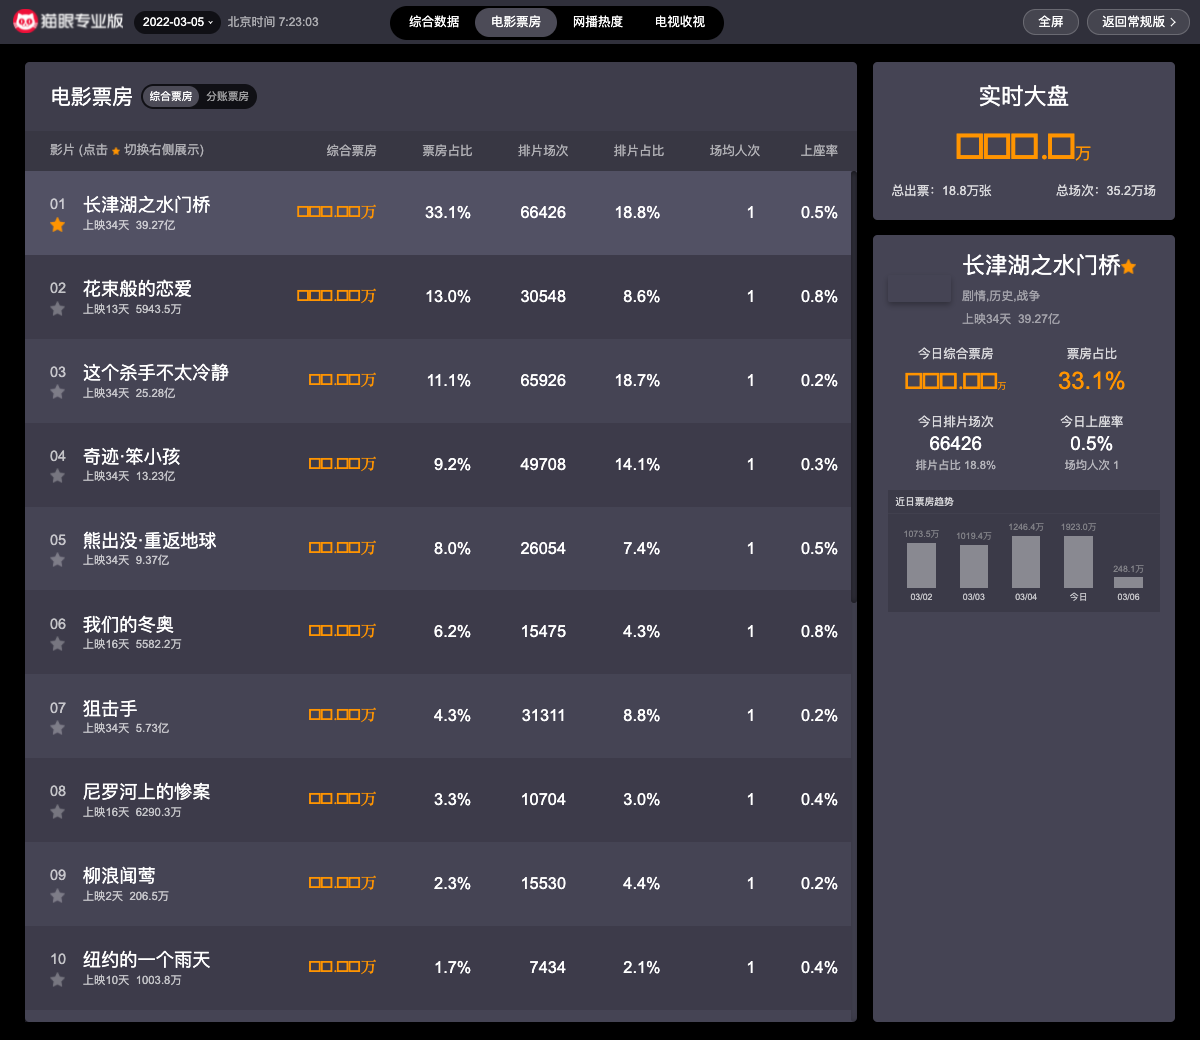

In [11]:
# Comparing with the screenshot earlier
from IPython.display import Image as displayImage
displayImage(filename="logs/" + now + "/screenshot.png") 

# Stage 2: Douban
## Search for movie names and get page sources

In [104]:
browserOptions = Options()
#browserOptions.add_argument("--headless")

capa = DesiredCapabilities.CHROME
capa["pageLoadStrategy"] = "none"
capa["goog:loggingPrefs"] = {"performance": "ALL"}
driver = webdriver.Chrome(desired_capabilities=capa, chrome_options=browserOptions)
wait = WebDriverWait(driver, 20)

driver.get("https://movie.douban.com/")

test = None
while not test:
    try:
        test = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'nav')))
    except:
        pass
        #driver.refresh();

jsonLst = []    
soupLst = []
percent1star, percent2star, percent3star, percent4star, percent5star = [], [], [], [], []
betterThan = []
shortReview, reviewRating, helpful, totalReviews = [], [], [], []
imdb = []
playSource = []

def search(name):
    inputElement = driver.find_element_by_id('inp-query')
    inputElement.send_keys(name)
    inputElement.send_keys(Keys.ENTER)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'cover-link')))
    firstMovie = driver.find_elements_by_class_name('cover-link')[0]
    firstMovie.click()
    res = requests.get(driver.current_url, headers=headers)
    soup = bs(res.text, 'lxml')
    soupLst.append(soup)
    
    if len(soup.select('span[class^="rating_per"]')) == 5:
        for i, x in enumerate(soup.select('span[class^="rating_per"]')):
            try:
                globals()['percent' + str(i + 1) + 'star'].append(x.text)
            except:
                globals()['percent' + str(i + 1) + 'star'].append(None)
    else: 
        for i in range(1, 6):
            globals()['percent' + str(i) + 'star'].append(None)
            
            
    try:
        playSource.append([x.text.strip() for x in soup.select('a[class^="playBtn"]')])
    except:
        playSource.append([])
            
    try:
        betterThan.append([x.text for x in soup.select('a[href^="/typerank?type_name="]')])
    except: 
        betterThan.append([])
        
    try: 
        shortReview.append([x.text for x in soup.select('span[class^="short"]')])
    except: 
        shortReview.append([])
        
    try:
        reviewRating.append([x.text for x in soup.select('span[class^="votes vote-count"]')])
    except: 
        reviewRating.append([])
        
    try:
        helpful.append([x['class'][0][-2:-1] for x in soup.select('span[class$="0 rating"]')])
    except:
        helpful.append([])
    
    try:
        totalReviews.append(soup.select_one('a[href$="comments?status=P"]').text.strip())
    except:
        totalReviews.append(None)
    
    try:
        imdb.append(re.search('IMDb:</span>(.*)<br/>', str(soup.select_one('div[id^="info"]')), re.IGNORECASE).group(1).strip())
    except:
        imdb.append(None)
        
    sj = json.loads(soup.select_one('script[type^="application/ld+json"]').text, strict=False)
    jsonLst.append(sj)

for i in df['movieInfo']:
    search(i)
    
df_douban = pd.DataFrame.from_records(infoLst)
df_douban.to_csv("logs/" + now + "/douban_data_raw.csv", encoding='utf_8_sig')

/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys
/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead


## Parse collected data and put into combined dataframe

In [107]:
def parsePeopleLst(lst):
    result = []
    for i in lst: 
        result.append(i['name'])
    return result

df_combined = df
df_combined['imdb'] = imdb
df_combined['duration'] = df_douban['duration']
df_combined['datePublished'] = df_douban['datePublished']
df_combined['genre'] = df_douban['genre']


for i in range(1, 6):
    df_combined['ratingPercentage' + str(i) + 'Star'] = globals()['percent' + str(i) + 'star']
df_combined['betterThan'] = betterThan
df_combined['shortReview'], df_combined['reviewRating'], df_combined['helpful'], df_combined['totalReviews'] = shortReview, reviewRating, helpful, totalReviews

df_combined['playSources'] = playSource

df_combined['director'] = df_douban['director'].apply(parsePeopleLst)
df_combined['author'] = df_douban['author'].apply(parsePeopleLst)
df_combined['actors'] = df_douban['actor'].apply(parsePeopleLst)
df_combined['description'] = df_douban['description']
df_combined['url'] = df_douban['url']
df_combined['doubanDataRaw'] = soupLst

df_combined.to_csv("logs/" + now + "/combined.csv", encoding='utf_8_sig')